In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from scipy.stats import multivariate_normal
import PIL

# 讀取資料

In [82]:
y = pd.read_csv('C:\\Users\\User\\Desktop\\機器學習\\HW3\\ML2021_HW3\\t_train.csv', header = None)
X = pd.read_csv('C:\\Users\\User\\Desktop\\機器學習\\HW3\\ML2021_HW3\\x_train.csv', header = None)
y = np.array(y)
X = np.array(X)

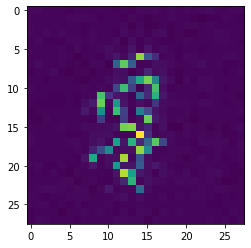

In [83]:
TEST = X[6].reshape((28, 28)) + np.random.normal(0, 1, size = (28, 28))
plt.imshow(TEST)

# Handmade PCA

In [84]:
class PCA:
    def __init__(self, data):
        self.Mean = np.mean(data, axis = 0)
        self.data = data - self.Mean
        self.ncol = data.shape[1]
        self.nrow = data.shape[0]
    def fit(self):
        COV = self.data.T@self.data * (1/(self.nrow - 1))
        self.values, self.vectors = np.linalg.eig(COV)
        #temp = [[i, self.values[i]] for i in range(self.ncol)]
        #temp.sort(key = lambda x: x[1], reverse = True)
        #temp = np.array(temp)
        #I = np.array(temp[:,0], dtype = int)
        #self.values = self.values[I].real
        #self.vectors = self.vectors[I].real
        self.values = self.values.real
        self.vectors = self.vectors.real
        #del temp
    def transform(self, data2):
        self.data2 = data2 - self.Mean
        return self.data2@self.vectors
    def variance(self):
        return self.values
    def variance_ratio(self):
        return self.values/np.sum(self.values)
    def select(self):
        temp = self.variance()
        N = np.sum(temp >= 0)
        return N

In [85]:
pca = PCA(X)
pca.fit()
# N = pca.select()
# 題目要求只取2個
N = 2
X_trans = pca.transform(X)[:,:N]

# Linear Kernel

In [86]:
def find(y, i):
    temp = (y == i)
    result = list()
    for obj in range(y.shape[0]):
        if temp[obj]:
            result += [obj]
    return result

In [87]:
def merge(y_hat, i, j):
    y = y_hat.reshape((-1, ))
    result = list()
    for idx in range(y.shape[0]):
        if (y[idx] == i) or (y[idx] == j):
            # print(y[idx], i, j)
            result += [idx]
    return result

In [88]:
# Package結果，給下面驗證用的
clf = svm.SVC(kernel = 'linear')
clf.fit(X_trans, y.reshape((-1,)))
clf = svm.SVC(kernel = 'linear', decision_function_shape = 'ovo')
clf.fit(X_trans, y.reshape((-1,)))
ans = np.sum(clf.predict(X_trans) == y.reshape((-1, )), dtype = int)/y.shape[0]
print('Training Accuracy :', np.round(ans,4)*100, '%')

Training Accuracy : 84.67 %


In [89]:
# Package結果，給下面驗證用的
clf = svm.SVC(kernel = 'linear')
clf.fit(X_trans, y.reshape((-1,)))
clf = svm.SVC(kernel = 'linear', decision_function_shape = 'ovr')
clf.fit(X_trans, y.reshape((-1,)))
ans = np.sum(clf.predict(X_trans) == y.reshape((-1, )), dtype = int)/y.shape[0]
print('Training Accuracy :', np.round(ans,4)*100, '%')

Training Accuracy : 84.67 %


## One-Versus-One

### Version 1

In [90]:
# 轉成下三角，方便之後分辨
def lower_trian(array1D, classes):
    result = np.zeros(shape = (classes, classes));
    row = 0;
    col = 0; 
    post = 2;
    for i in range(array1D.shape[0]):
        row += 1;
        if (row) >= classes:
            col += 1;
            row = post;
            post += 1;
        result[row][col] = array1D[i];
    return result

# 輸出預測
# 寫出Decision Function
Decision_Function = X_trans@clf.coef_.T + clf.intercept_
predict = list()
# 每個Decision Function投票認為是哪個類別，採多數決
for vector in (Decision_Function):
    scores = np.zeros(shape = (3,), dtype = int)
    temp = lower_trian(vector, np.max(y)+1)
    for j in range(np.max(y) + 1):
        for i in range(j + 1, np.max(y) + 1):
            if temp[i][j] > 0:
                scores[j] += 1
            else:
                scores[i] += 1
    predict.append(np.argmax(scores))

In [91]:
ans = np.sum(np.array(predict) == y.reshape((-1, )), dtype = int)/y.shape[0]
print('Training Accuracy :', np.round(ans,4)*100, '%')

Training Accuracy : 84.67 %


### Version 2

In [92]:
result = list()
for i in range(3):
    for j in range(i+1, 3):
        Alist = merge(y, i, j)
        # magic number = 1139967
        clf = svm.SVC(kernel = 'linear')
        y_trans = y.reshape((-1,))[Alist]
        y_trans = np.where(y_trans == i, 1, -1)
        clf.fit(X_trans[Alist], y_trans.reshape((-1,)))
        weight = clf.dual_coef_@clf.support_vectors_
        result.append([[i, j], weight, clf.intercept_, clf.support_])

vote = np.zeros(shape = (X_trans.shape[0], 3))
for vect in result:
    weight = vect[1]
    intercept_ = vect[2]
    DF = (X_trans@weight.T + intercept_).reshape((300, ))
    vote[:,vect[0][0]] += (DF > 0)
    vote[:,vect[0][1]] += (DF <= 0)
    predict = np.argmax(vote, axis = 1)

In [93]:
ans = np.sum(np.array(predict) == y.reshape((-1, )), dtype = int)/y.shape[0]
print('Training Accuracy :', np.round(ans,4)*100, '%')

Training Accuracy : 84.67 %


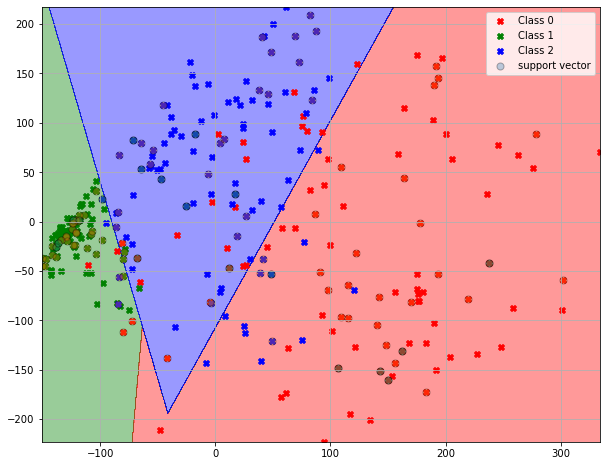

In [101]:
Alist = find(y, 0)
Blist = find(y, 1)
Clist = find(y, 2)
LIST = [(Alist, Blist), (Alist, Clist), (Blist, Clist)]
nlist = []
# 圖大小設定
plt.figure(figsize = (10, 8))

xx = np.linspace(np.min(X_trans[:,0]), np.max(X_trans[:,0]) ,2000) 
yy = np.linspace(np.min(X_trans[:,1]), np.max(X_trans[:,1]) ,2000) 
xx, yy = np.meshgrid(xx, yy)

vote = np.zeros(shape = (xx.reshape((-1,)).shape[0], 3))
for vect in result:
    weight = vect[1]
    intercept_ = vect[2]
    DF = (xx.reshape((-1,))*weight[0][0] + yy.reshape((-1,))*weight[0][1] + intercept_).reshape((-1, ))
    vote[:,vect[0][0]] += (DF > 0)
    vote[:,vect[0][1]] += (DF <= 0)
    predict = np.argmax(vote, axis = 1)

plt.contourf(xx, yy, predict.reshape(xx.shape), cmap = ListedColormap(['r', 'g', 'b'], name = 'from_list', N = None), alpha = 0.4)

# 開頭
plt.xlim(np.min(X_trans[:,0]), np.max(X_trans[:,0]))
plt.ylim(np.min(X_trans[:,1]), np.max(X_trans[:,1]))

# 散佈圖，以PCA資料並index各自類別後上色。
# np沒有以address位置作為index，因此是由X_trans進行採點
plt.scatter(X_trans[Alist,0], X_trans[Alist, 1], color = 'r', marker = 'X', label = 'Class 0')
plt.scatter(X_trans[Blist,0], X_trans[Blist, 1], color = 'g', marker = 'X', label = 'Class 1')
plt.scatter(X_trans[Clist,0], X_trans[Clist, 1], color = 'b', marker = 'X', label = 'Class 2')

plt.scatter(temp[:,0], temp[:,1], marker = 'o',color = None, edgecolor = 'black',s = 50, label = 'support vector', alpha = 0.3)
for c in range(1,3):
    temp = X_trans[result[c][3]]
    plt.scatter(temp[:,0], temp[:,1], marker = 'o',color = None, edgecolor = 'black',s = 50, alpha = 0.3)

plt.legend()
plt.grid()
plt.show()

## One-Versus-All

In [102]:
result = list()
for i in range(3):
    clf = svm.SVC(kernel = 'linear')
    y_trans = y.reshape((-1,))
    y_trans = np.where(y_trans == i, 1, -1)
    clf.fit(X_trans, y_trans.reshape((-1,)))
    weight = clf.dual_coef_@clf.support_vectors_
    result.append([i, weight, clf.intercept_, clf.support_])

ANS = np.zeros(shape = (X_trans.shape[0], 3))

for vect in result:
    weight = vect[1]
    intercept_ = vect[2]
    DF = (X_trans@weight.T + intercept_).reshape((300, ))
    ANS[:, vect[0]] += DF
    predict = np.argmax(ANS, axis = 1)

In [103]:
ans = np.sum(np.array(predict) == y.reshape((-1, )), dtype = int)/y.shape[0]
print('Training Accuracy :', np.round(ans,4)*100, '%')

Training Accuracy : 81.33 %


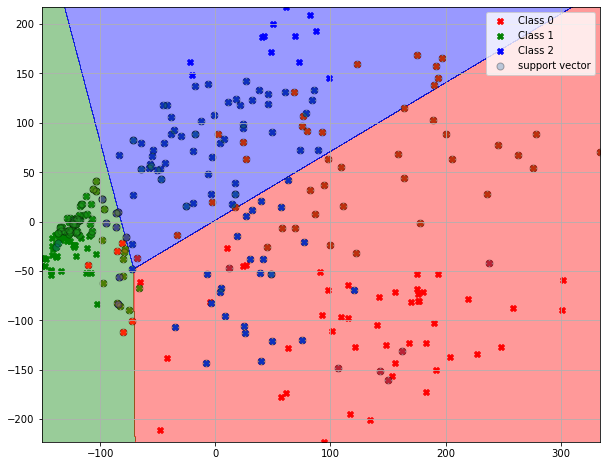

In [104]:
Alist = find(y, 0)
Blist = find(y, 1)
Clist = find(y, 2)
LIST = [(Alist, Blist), (Alist, Clist), (Blist, Clist)]
nlist = []
# 圖大小設定
plt.figure(figsize = (10, 8))

xx = np.linspace(np.min(X_trans[:,0]), np.max(X_trans[:,0]) ,2000) 
yy = np.linspace(np.min(X_trans[:,1]), np.max(X_trans[:,1]) ,2000) 
xx, yy = np.meshgrid(xx, yy)

vote = np.zeros(shape = (xx.reshape((-1,)).shape[0], 3))
for vect in result:
    weight = vect[1]
    intercept_ = vect[2]
    DF = (xx.reshape((-1,))*weight[0][0] + yy.reshape((-1,))*weight[0][1] + intercept_).reshape((-1, ))
    vote[:,vect[0]] += (DF)
predict = np.argmax(vote, axis = 1)

plt.contourf(xx, yy, predict.reshape(xx.shape), cmap = ListedColormap(['r', 'g', 'b'], name = 'from_list', N = None), alpha = 0.4)

# 開頭
plt.xlim(np.min(X_trans[:,0]), np.max(X_trans[:,0]))
plt.ylim(np.min(X_trans[:,1]), np.max(X_trans[:,1]))

# 散佈圖，以PCA資料並index各自類別後上色。
# np沒有以address位置作為index，因此是由X_trans進行採點
plt.scatter(X_trans[Alist,0], X_trans[Alist, 1], color = 'r', marker = 'X', label = 'Class 0')
plt.scatter(X_trans[Blist,0], X_trans[Blist, 1], color = 'g', marker = 'X', label = 'Class 1')
plt.scatter(X_trans[Clist,0], X_trans[Clist, 1], color = 'b', marker = 'X', label = 'Class 2')

plt.scatter(temp[:,0], temp[:,1], marker = 'o',color = None, edgecolor = 'black',s = 50, label = 'support vector', alpha = 0.3)
for c in range(1,3):
    temp = X_trans[result[c][3]]
    plt.scatter(temp[:,0], temp[:,1], marker = 'o',color = None, edgecolor = 'black',s = 50, alpha = 0.3)

plt.legend()
plt.grid()
plt.show()

# Polynomial (homogeneous) kernel of degree 2

In [105]:
X_Trans = np.zeros(shape = (X_trans.shape[0], 3))
X_Trans[:,0] = X_trans[:,0]**2
X_Trans[:,1] = X_trans[:,0]*X_trans[:,1]*np.sqrt(2)
X_Trans[:,2] = X_trans[:,1]**2

## One-Versus-One

In [120]:
result = list()
for i in range(3):
    for j in range(i+1, 3):
        Alist = merge(y, i, j)
        # magic number = 1139967
        clf = svm.SVC(kernel = 'linear')
        y_trans = y.reshape((-1,))[Alist]
        y_trans = np.where(y_trans == i, 1, -1)
        clf.fit(X_Trans[Alist], y_trans.reshape((-1,)))
        weight = clf.dual_coef_@clf.support_vectors_
        result.append([[i, j], weight, clf.intercept_, clf.support_])

vote = np.zeros(shape = (X_Trans.shape[0], 3))
for vect in result:
    weight = vect[1]
    intercept_ = vect[2]
    DF = (X_Trans@weight.T + intercept_).reshape((300, ))
    vote[:,vect[0][0]] += (DF > 0)
    vote[:,vect[0][1]] += (DF <= 0)
predict = np.argmax(vote, axis = 1)

In [121]:
ans = np.sum(np.array(predict) == y.reshape((-1, )), dtype = int)/y.shape[0]
print('Training Accuracy :', np.round(ans,4)*100, '%')

Training Accuracy : 78.67 %


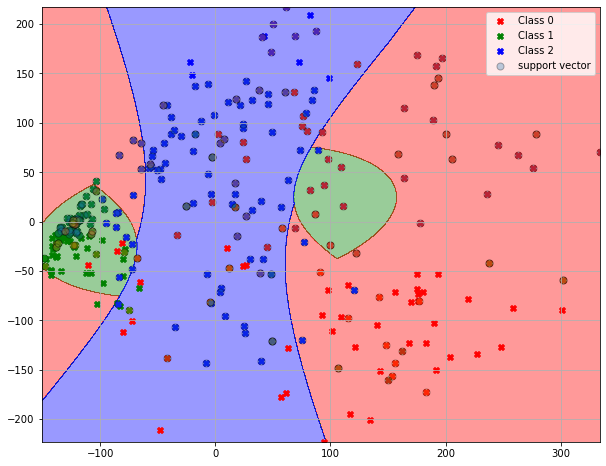

In [122]:
Alist = find(y, 0)
Blist = find(y, 1)
Clist = find(y, 2)
LIST = [(Alist, Blist), (Alist, Clist), (Blist, Clist)]
nlist = []
# 圖大小設定
plt.figure(figsize = (10, 8))

xx = np.linspace(np.min(X_trans[:,0]), np.max(X_trans[:,0]) ,2000) 
yy = np.linspace(np.min(X_trans[:,1]), np.max(X_trans[:,1]) ,2000)
xx, yy = np.meshgrid(xx, yy)

XX = np.zeros(shape = (xx.reshape((-1,)).shape[0], 3))
XX[:,0] = xx.reshape((-1,))**2
XX[:,1] = yy.reshape((-1,))*xx.reshape((-1,))*np.sqrt(2)
XX[:,2] = yy.reshape((-1,))**2

vote = np.zeros(shape = (xx.reshape((-1,)).shape[0], 3))
for vect in result:
    weight = vect[1]
    intercept_ = vect[2]
    DF = (XX[:,0].reshape((-1,))*weight[0][0] + XX[:,1].reshape((-1,))*weight[0][1] + XX[:,2].reshape((-1,))*weight[0][2] +intercept_).reshape((-1, ))
    vote[:,vect[0][0]] += (DF > 0)
    vote[:,vect[0][1]] += (DF <= 0)
predict = np.argmax(vote, axis = 1)

plt.contourf(xx, yy, predict.reshape(xx.shape), cmap = ListedColormap(['r', 'g', 'b'], name = 'from_list', N = None), alpha = 0.4)

# 開頭
plt.xlim(np.min(X_trans[:,0]), np.max(X_trans[:,0]))
plt.ylim(np.min(X_trans[:,1]), np.max(X_trans[:,1]))

# 散佈圖，以PCA資料並index各自類別後上色。
# np沒有以address位置作為index，因此是由X_trans進行採點
plt.scatter(X_trans[Alist,0], X_trans[Alist, 1], color = 'r', marker = 'X', label = 'Class 0')
plt.scatter(X_trans[Blist,0], X_trans[Blist, 1], color = 'g', marker = 'X', label = 'Class 1')
plt.scatter(X_trans[Clist,0], X_trans[Clist, 1], color = 'b', marker = 'X', label = 'Class 2')

plt.scatter(temp[:,0], temp[:,1], marker = 'o',color = None, edgecolor = 'black',s = 50, label = 'support vector', alpha = 0.3)
for c in range(1,3):
    temp = X_trans[result[c][3]]
    plt.scatter(temp[:,0], temp[:,1], marker = 'o',color = None, edgecolor = 'black',s = 50, alpha = 0.3)

plt.legend()
plt.grid()
plt.show()

## One-Versus-All

In [129]:
ANS.shape

(300, 3)

In [123]:
result = list()
for i in range(3):
    clf = svm.SVC(kernel = 'linear')
    y_trans = y.reshape((-1,))
    y_trans = np.where(y_trans == i, 1, -1)
    clf.fit(X_Trans, y_trans.reshape((-1,)))
    weight = clf.dual_coef_@clf.support_vectors_
    result.append([i, weight, clf.intercept_, clf.support_])

for vect in result:
    weight = vect[1]
    intercept_ = vect[2]
    DF = (X_Trans@weight.T + intercept_).reshape((300, ))
    ANS[:, vect[0]] += DF
    predict = np.argmax(ANS, axis = 1)

In [137]:
ans = np.sum(np.array(predict) == y.reshape((-1, )), dtype = int)/y.shape[0]
print('Training Accuracy :', np.round(ans,4)*100, '%')

Training Accuracy : 78.67 %


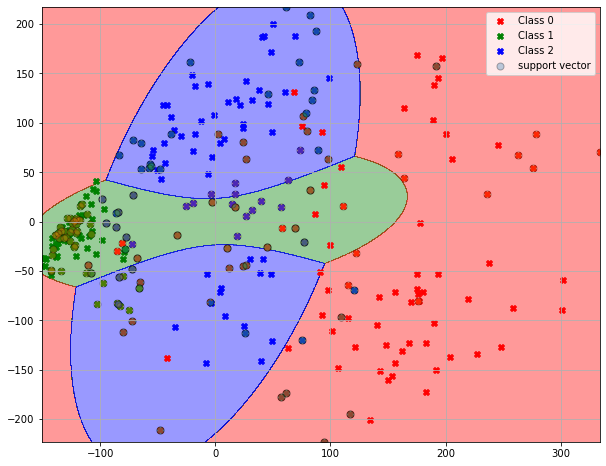

In [143]:
Alist = find(y, 0)
Blist = find(y, 1)
Clist = find(y, 2)
LIST = [(Alist, Blist), (Alist, Clist), (Blist, Clist)]
nlist = []
# 圖大小設定
plt.figure(figsize = (10, 8))

xx = np.linspace(np.min(X_trans[:,0]), np.max(X_trans[:,0]) ,2000) 
yy = np.linspace(np.min(X_trans[:,1]), np.max(X_trans[:,1]) ,2000)
xx, yy = np.meshgrid(xx, yy)

XX = np.zeros(shape = (xx.reshape((-1,)).shape[0], 3))
XX[:,0] = xx.reshape((-1,))**2
XX[:,1] = yy.reshape((-1,))*xx.reshape((-1,))*np.sqrt(2)
XX[:,2] = yy.reshape((-1,))**2

vote = np.zeros(shape = (xx.reshape((-1,)).shape[0], 3))
for vect in result:
    weight = vect[1]
    intercept_ = vect[2]
    DF = (XX[:,0].reshape((-1,))*weight[0][0] + XX[:,1].reshape((-1,))*weight[0][1] + XX[:,2].reshape((-1,))*weight[0][2] +intercept_).reshape((-1, ))
    vote[:, vect[0]] += DF
predict = np.argmax(vote, axis = 1)

plt.contourf(xx, yy, predict.reshape(xx.shape), cmap = ListedColormap(['r', 'g', 'b'], name = 'from_list', N = None), alpha = 0.4)

# 開頭
plt.xlim(np.min(X_trans[:,0]), np.max(X_trans[:,0]))
plt.ylim(np.min(X_trans[:,1]), np.max(X_trans[:,1]))

# 散佈圖，以PCA資料並index各自類別後上色。
# np沒有以address位置作為index，因此是由X_trans進行採點
plt.scatter(X_trans[Alist,0], X_trans[Alist, 1], color = 'r', marker = 'X', label = 'Class 0')
plt.scatter(X_trans[Blist,0], X_trans[Blist, 1], color = 'g', marker = 'X', label = 'Class 1')
plt.scatter(X_trans[Clist,0], X_trans[Clist, 1], color = 'b', marker = 'X', label = 'Class 2')

plt.scatter(temp[:,0], temp[:,1], marker = 'o',color = None, edgecolor = 'black',s = 50, label = 'support vector', alpha = 0.3)
for c in range(1,3):
    temp = X_trans[result[c][3]]
    plt.scatter(temp[:,0], temp[:,1], marker = 'o',color = None, edgecolor = 'black',s = 50, alpha = 0.3)

plt.legend()
plt.grid()
plt.show()

# Gaussian Mixture

In [149]:
os.listdir(Path)

['ML2021_HW3', 'ML2021_HW3.zip']

In [312]:
Data = list()
Path = os.getcwd()
# C:\Users\User\Desktop\機器學習\HW3
Path += '\\Desktop\\機器學習\\HW3\\' # Find the path
for i in os.listdir(Path):
    try:
        temp = Path
        temp += '\\'
        temp += i
        for obj in os.listdir(temp):
            Temp = temp
            Temp += '\\'
            Temp += obj
            ### Here I print all the path of the jpg files in my pc.
            print(Temp)
            IM = PIL.Image.open(Temp)
            Data.append(IM.load())
        del Temp, temp, Path
    except:
        continue
print('\nData Reading is done')
#C:\Users\User\Desktop\ML\HW2\EMNIST\a

C:\Users\User\Desktop\機器學習\HW3\\ML2021_HW3\hw3.jpg
C:\Users\User\Desktop\機器學習\HW3\\ML2021_HW3\hw3_StudentID.ipynb

Data Reading is done


In [313]:
data = list()
for index in range(len(Data)):
    Temp = list()
    for i in range(IM.size[1]):
        temp = list()
        for j in range(IM.size[0]):
            temp.append(Data[index][j, i])
        Temp.append(temp)
    data.append(np.array(Temp))

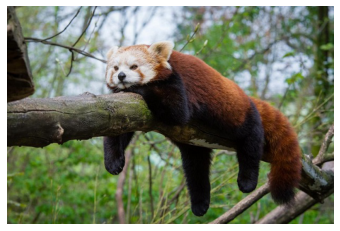

In [316]:
plt.imshow(data[0])
plt.axis('off')
plt.show()

In [1043]:
img = data[0]
class Gaussian_Matrix:
    def __init__(self, img, CLASS, channel):
        # 參數設定
        self.k = CLASS;
        self.data = img
        self.channel = channel
    
    def initialize(self):
        # 由kmeans做initialize
        print('------initializing------')
        List = [i for i in range(self.data.reshape((-1, self.channel)).shape[0])]
        I = np.random.choice(List, size = (self.k, ))
        means =  self.data.reshape((-1, self.channel))[I]# (先隨機選點)
        epsilon = np.ones(shape = (self.k, self.channel)) * 0.0003 # 設定終止條件
        break_point = np.ones(shape = (self.k, self.channel)) # 設定終止點
        epoch = 0
        distances = np.zeros(shape = (self.data.shape[0]*self.data.shape[1], self.k)) # 距離矩陣(所有格子, channel)
        max_iter = 100
        Dist = list()
        while (break_point > epsilon).all() and epoch <= max_iter:
            epoch += 1           
            # global memory set up: 類別平均
            Means = np.zeros(shape = (self.k, self.channel)) # 各類別之channel(特徵)
            # global memory set up: 計數
            count = np.zeros(shape = (self.k, ))
            # data flatten
            Data = self.data.reshape((-1, 3))           
            # 距離means直向複製Data.shape[0]個，並且全部相減作為第k類的距離
            for k in range(self.k): # 第k類
                distances[:,k] = np.sum((Data - np.tile(means[k,:],(Data.shape[0], 1)))**2,1)  # means是第k類, 所有channel
            Dist.append(np.sum(np.sqrt(distances)))
            # 紀錄最短的即該類
            Temp = np.argmin(distances, axis = 1)
            # 轉置即所求
            temp = Temp.reshape(self.data.shape[0], self.data.shape[1])
            # k個類別的Means
            for k in range(self.k):
                # channel分開處理
                for c in range(self.channel):
                    Means[k, c] = np.sum((Temp == k)*Data[:,c])
                # 平均化
                a = np.where(Temp == k, 1, 0)
                count[k] = np.sum(a)
                if count[k]:
                    Means[k] /= count[k]
                else:
                    Means[k] = 0
            
            # 終止條件：只要各個位置的means皆收斂到Means(即更新不大)，則break
            break_point = np.absolute(Means - means)
            
            # 計算變異數，可能有誤******
            variances = np.zeros((self.k, self.channel, self.channel))
            for k in range(self.k):
                A = np.tile((Temp == k).T, (self.channel, 1))*(Data.T - np.tile(means[k,:],(Data.shape[0], 1)).T)
                variances[k] += (A@A.T)
                if count[k]:
                    variances[k] /= count[k]
                else:
                    variances[k] = np.zeros(shape = (self.channel, self.channel))
            
            # 更新
            means = np.copy(Means)
            self.variances = np.copy(variances)
            self.Means = np.copy(means)
            self.pi = count / (self.data.shape[0]*self.data.shape[1]) # shape = (k, )
        return self.variances, self.Means
        '''
        plt.figure(figsize = (8, 6))
        plt.plot([i + 1 for i in range(epoch)], Dist, '--', label = 'kmeans_training_curve')
        plt.grid()
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('kmeans_total_distances')
        plt.show()
        '''
        
    def fit(self):
        channel = 3;
        # 初始化
        self.initialize();
        # 訓練
        rnk = np.zeros(shape = (self.data.shape[0], self.data.shape[1], self.k))
        epoch = 0
        Nk = np.zeros(shape = (self.k, ))
        # 給畫圖用
        self.probs = list()
        print('--------------start--------------')
        break_point = np.ones(shape = (self.k, self.channel))
        epsilon = np.ones(shape = (self.k, self.channel)) * 0.0003
        max_iter = 100
        while (break_point > epsilon).all() and epoch < max_iter:
            self.LIKELIHOOD = self.log_likelihood(self.Means, self.variances)
            print('epoch:', epoch + 1, '----log_likelihood:', end = ' ')
            
            # 設定最終結果的means
            Means = np.zeros(shape = (self.k, self.channel))
            # 所有的資料進來並且轉置
            xn = self.data.reshape((-1, self.channel))
            # 設定mix_gaussian的值, 共有k個類別對應每個資料點
            mix_gaussian = np.zeros(shape = (xn.shape[0], self.k))
            # 每個類別k，各自處理；全部的資料放進來，以3個channel為joint形成機率分佈
            for k in range(self.k):
                mix_gaussian[:, k] = self.pi[k]*multivariate_normal.pdf(xn, self.Means[k], self.variances[k])
            # 三個類別的機率相加，並且對到每個data point上
            SUM = np.sum(mix_gaussian, axis = 1)
            # 資料轉成格子行式，每個Gaussian有k個機率
            mix_gaussian = mix_gaussian.reshape((self.data.shape[0], self.data.shape[1], self.k))
            # mix_gaussian = mix_gaussian.reshape((self.k, self.data.shape[0], self.data.shape[1]))
            SUM = SUM.reshape((self.data.shape[0], self.data.shape[1]))
            
            # 計算Z(rnk)的值
            for k in range(self.k):
                # 只拿出第k個機率出來
                MG = mix_gaussian[:,:,k]
                # MG = MG.reshape((self.data.shape[0], self.data.shape[1]))
                for row in range(self.data.shape[0]):
                    for col in range(self.data.shape[1]):
                        #print((MG[:, k]/SUM[row, :])[0])
                        # 將對應到各個資料點的機率抓出來，除掉機率總和
                        coef = MG[row ,col]/SUM[row, col]
                        # 再放到對應的rnk裡面
                        rnk[row, col, k] = coef
            # 平均值更新
            for i in range(self.k):
                # 固定某一個類別k，然後將這個類別的所有值合在一起
                Nk[i] = np.sum(rnk[:, :, i])
                # 把rnk複製3個row出來，rnk的大小是img.shape[0], img.shape[1], k(k個類別)
                RNK = np.tile(rnk[:,:,i], (self.channel, 1, 1))
                # 所以RNK是channel, img.shape[0], img.shape[1]
                for c in range(self.channel):
                    # 將rnk(channel, img.shape[0], img.shape[1])乘上data(也是channel, img.shape[0], img.shape[1])
                    # 然後第c個channel放到Means的第c個channel
                    Means[i, c] += np.sum((RNK*self.data.reshape(self.channel, self.data.shape[0], self.data.shape[1]))[c])

            # As the reference to p.438, reestmimate the means and update
            # 也就是Means的部分除以Nk
            for k in range(self.k):
                Means[k] = Means[k] / Nk[k]
            # Update
            break_point = np.absolute(self.Means - Means)
            self.Means = np.copy(Means)

            # 變異數更新
            # 變異數共有k類，每類是channel*channel的矩陣
            variances = np.zeros(shape = (self.k, self.channel, self.channel))
            for row in range(self.data.shape[0]):
                for col in range(self.data.shape[1]):
                    # 把每個點拿出來，並且轉成channel, 1
                    xn = self.data[row, col].reshape((self.channel, -1))
                    for k in range(self.k):
                        # 各個類別k的Means拿出來，並且轉成channel, 1
                        inner = self.Means[k].reshape((self.channel, 1))
                        # 相減就是chaanel * channel
                        squared = (xn - inner)@(xn - inner).T
                        # 每個點的平方差*rnk加到各個類別variances
                        variances[k] += rnk[row, col, k]*squared
            # pi更新
            pi = np.zeros(shape = (self.k, ))
            # variances去做平均，就是除以Nk
            for k in range(self.k):
                variances[k] /= Nk[k]
                # 每個pi就是Nk/N
                pi[k] = Nk[k]/(self.data.shape[0]*self.data.shape[1])
                
            # 要畫curve用的資料存取
            self.LIKELIHOOD = self.log_likelihood(self.Means, self.variances)
            print(self.LIKELIHOOD, end = '\n')
            self.probs.append(self.LIKELIHOOD)
            
            # 把值update上去
            self.pi = np.copy(pi)
            self.variances = np.copy(variances)
            epoch += 1
            self.iter = epoch
        Dist = list()
        Data = self.data.reshape((-1, 3))
        distances = np.zeros(shape = (self.data.shape[0]*self.data.shape[1], self.k))
        for k in range(self.k): # 第k類
            distances[:,k] = np.sum((Data - np.tile(self.Means[k,:],(Data.shape[0], 1)))**2,1)  # means是第k類, 所有channel
        Dist.append(np.sum(np.sqrt(distances)))
        Temp = np.argmin(distances, axis = 1)
        return self.Means, Temp
        '''
        # 圖片結果儲存
        output = np.copy(self.data)
        for row in range(self.data.shape[0]):
            for col in range(self.data.shape[1]):
                xn = output[row][col].reshape((self.channel, 1))
                p = np.zeros(shape = (self.k, ))
                for k in range(self.k):
                    p[k] = multivariate_normal.pdf(xn, self.Means[k], self.variances[k])
                output[row][col] = self.Means[np.argmax(p)] * 255.
        self.iter = epoch
        return output
        '''
    
    def curve_plot(self):
        A = [i+1 for i in range(self.iter)]
        plt.figure(figsize = (10, 8))
        plt.plot(A, self.probs)
        plt.xlabel('Epochs')
        plt.ylabel('log_likelihood')
        plt.grid()
        plt.show()
        
    def log_likelihood(self, mean, variance):
        result = 0.0;
        # 設定一個local memory，裡面是 (img.shape[0]*img.shape[1], k)
        temp = np.zeros(shape = (self.data.shape[0]*self.data.shape[1], self.k))
        # 每個類別k去計算
        for k in range(self.k):
            # 各個類別中，pi*N(Xn|mu_k, sigma_k)存到local memory
            temp[:, k] = self.pi[k]*multivariate_normal.pdf(self.data.reshape((-1, 3)), mean[k], variance[k])
        # 各k類別的pi機率先加起來
        Temp = np.sum(temp, axis = 1)
        # 再取log相加
        result = np.sum(np.log(Temp))
        return result
        
# Gaussian_Matrix(img, 3, 3).fit()

## k = 3

In [1044]:
A= Gaussian_Matrix(img, 3, 3)
cent, pred = A.fit()

------initializing------
--------------start--------------
epoch: 1 ----log_likelihood: -5521782.729094084
epoch: 2 ----log_likelihood: -3893480.8649952654
epoch: 3 ----log_likelihood: -3878434.2118298127
epoch: 4 ----log_likelihood: -3871282.5423602434
epoch: 5 ----log_likelihood: -3867427.422881688
epoch: 6 ----log_likelihood: -3865493.1863540714
epoch: 7 ----log_likelihood: -3864530.5569052757
epoch: 8 ----log_likelihood: -3864076.2606917964
epoch: 9 ----log_likelihood: -3863914.4366217493
epoch: 10 ----log_likelihood: -3863927.9939154764
epoch: 11 ----log_likelihood: -3864045.9880615375
epoch: 12 ----log_likelihood: -3864222.81901134
epoch: 13 ----log_likelihood: -3864428.61489725
epoch: 14 ----log_likelihood: -3864644.088290685
epoch: 15 ----log_likelihood: -3864857.2481973693
epoch: 16 ----log_likelihood: -3865061.065916256
epoch: 17 ----log_likelihood: -3865251.793690235
epoch: 18 ----log_likelihood: -3865427.781615149
epoch: 19 ----log_likelihood: -3865588.670491052
epoch: 20 -

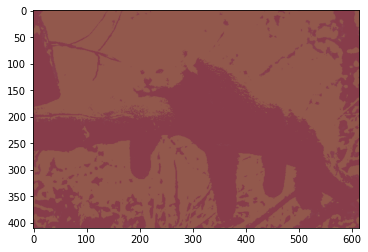

In [1045]:
test = np.zeros(shape = (pred.shape[0], 3))
for idx, l in enumerate(pred):
    test[idx, l] += 1
plt.imshow(np.array((test@cent).reshape((410, 615, 3)),dtype = int))
plt.show()

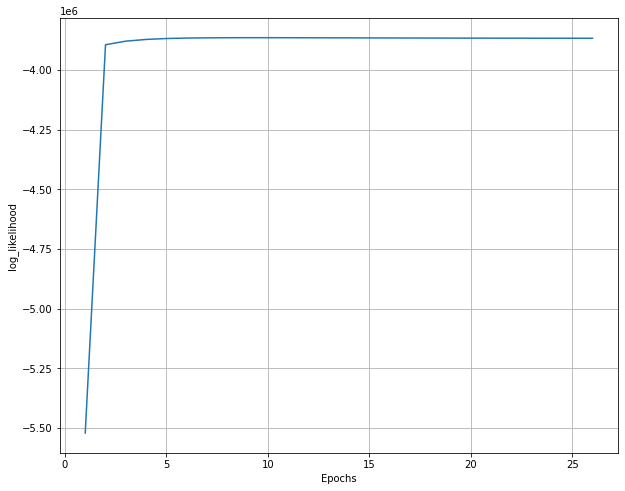

In [1046]:
A.curve_plot()

## k = 7

In [1047]:
A = Gaussian_Matrix(img, 7, 3)
cent, pred = A.fit()

------initializing------
--------------start--------------
epoch: 1 ----log_likelihood: -7524795.831805095
epoch: 2 ----log_likelihood: -3874477.7670964194
epoch: 3 ----log_likelihood: -3862708.0244362676
epoch: 4 ----log_likelihood: -3859100.5334601155
epoch: 5 ----log_likelihood: -3856679.785773372
epoch: 6 ----log_likelihood: -3854914.1811542553
epoch: 7 ----log_likelihood: -3853634.7482559904
epoch: 8 ----log_likelihood: -3852739.801920129
epoch: 9 ----log_likelihood: -3852143.8376320703
epoch: 10 ----log_likelihood: -3851766.2962283255
epoch: 11 ----log_likelihood: -3851534.080218896
epoch: 12 ----log_likelihood: -3851385.6124837524
epoch: 13 ----log_likelihood: -3851272.457275212
epoch: 14 ----log_likelihood: -3851159.3120877203
epoch: 15 ----log_likelihood: -3851023.1836404507


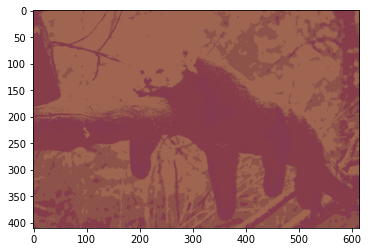

In [1048]:
test = np.zeros(shape = (pred.shape[0], 7))
for idx, l in enumerate(pred):
    test[idx, l] += 1
plt.imshow(np.array((test@cent).reshape((410, 615, 3)),dtype = int))
plt.show()

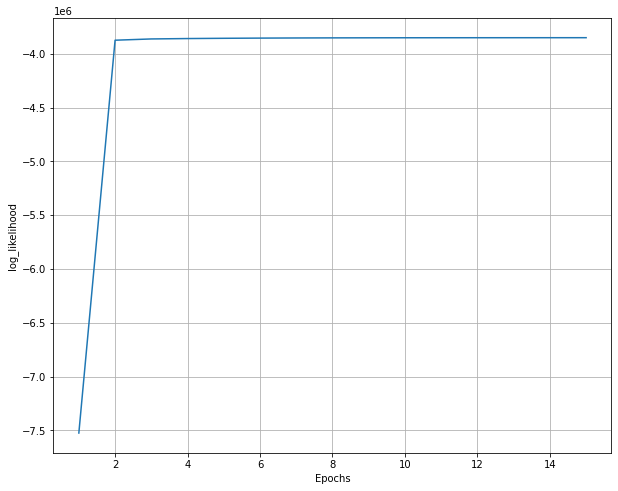

In [1049]:
A.curve_plot()

## k = 10

In [1050]:
A = Gaussian_Matrix(img, 10, 3)
cent, pred = A.fit()

------initializing------
--------------start--------------
epoch: 1 ----log_likelihood: -7534924.312378836
epoch: 2 ----log_likelihood: -3866314.8080046787
epoch: 3 ----log_likelihood: -3856743.2720542285
epoch: 4 ----log_likelihood: -3853187.626967818
epoch: 5 ----log_likelihood: -3850775.095136352
epoch: 6 ----log_likelihood: -3848510.3201992163
epoch: 7 ----log_likelihood: -3846586.360613227
epoch: 8 ----log_likelihood: -3845475.838533959
epoch: 9 ----log_likelihood: -3844755.2712020003
epoch: 10 ----log_likelihood: -3844229.249770665
epoch: 11 ----log_likelihood: -3843838.891739012


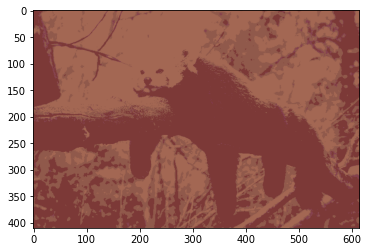

In [1051]:
test = np.zeros(shape = (pred.shape[0], 10))
for idx, l in enumerate(pred):
    test[idx, l] += 1
plt.imshow(np.array((test@cent).reshape((410, 615, 3)),dtype = int))
plt.show()

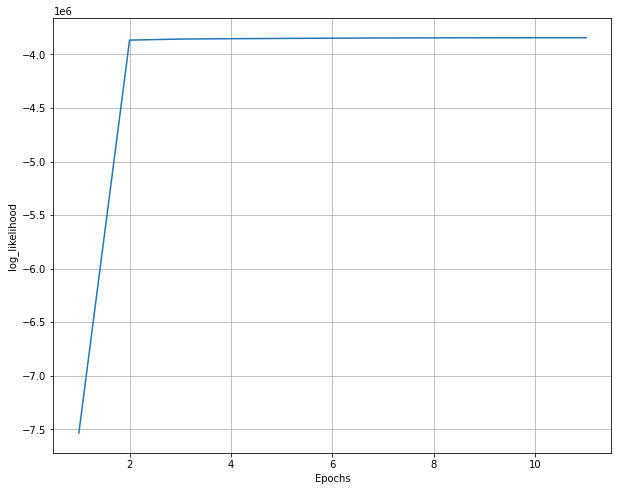

In [1052]:
A.curve_plot()

## k = 30

In [1053]:
A = Gaussian_Matrix(img, 30, 3)
cent, pred = A.fit()

------initializing------
--------------start--------------
epoch: 1 ----log_likelihood: -9275122.806218052
epoch: 2 ----log_likelihood: -3871296.511236614
epoch: 3 ----log_likelihood: -3848435.1304780818
epoch: 4 ----log_likelihood: -3846237.0669814576
epoch: 5 ----log_likelihood: -3844462.275202621
epoch: 6 ----log_likelihood: -3842895.3444428593
epoch: 7 ----log_likelihood: -3841856.4165828796
epoch: 8 ----log_likelihood: -3841163.4303439404
epoch: 9 ----log_likelihood: -3840465.1557412082
epoch: 10 ----log_likelihood: -3839929.832907169


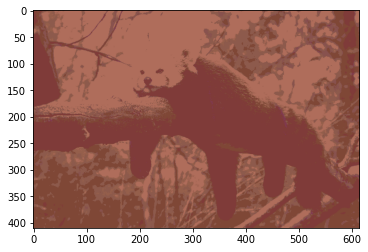

In [1054]:
test = np.zeros(shape = (pred.shape[0], 30))
for idx, l in enumerate(pred):
    test[idx, l] += 1
plt.imshow(np.array((test@cent).reshape((410, 615, 3)),dtype = int))
plt.show()

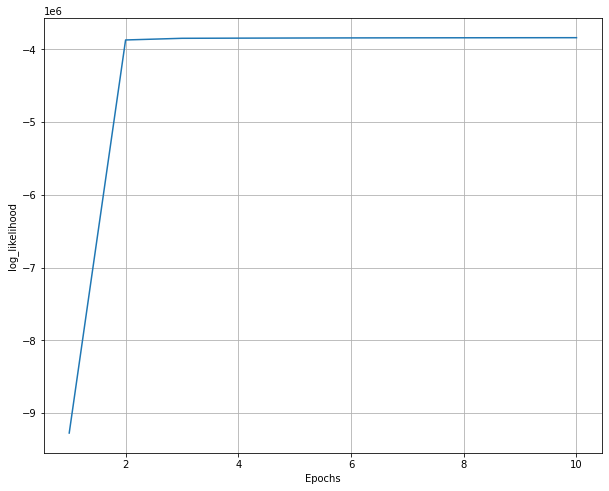

In [1055]:
A.curve_plot()

# Plot learning curve

In [1056]:
img = data[0]
class Gaussian_Matrix:
    def __init__(self, img, CLASS, channel):
        # 參數設定
        self.k = CLASS;
        self.data = img
        self.channel = channel
    
    def initialize(self):
        # 由kmeans做initialize
        print('------initializing------')
        List = [i for i in range(self.data.reshape((-1, self.channel)).shape[0])]
        I = np.random.choice(List, size = (self.k, ))
        means =  self.data.reshape((-1, self.channel))[I]# (先隨機選點)
        epsilon = np.ones(shape = (self.k, self.channel)) * 0.0003 # 設定終止條件
        break_point = np.ones(shape = (self.k, self.channel)) # 設定終止點
        epoch = 0
        distances = np.zeros(shape = (self.data.shape[0]*self.data.shape[1], self.k)) # 距離矩陣(所有格子, channel)
        max_iter = 100
        Dist = list()
        while (break_point > epsilon).all() and epoch <= max_iter:
            epoch += 1           
            # global memory set up: 類別平均
            Means = np.zeros(shape = (self.k, self.channel)) # 各類別之channel(特徵)
            # global memory set up: 計數
            count = np.zeros(shape = (self.k, ))
            # data flatten
            Data = self.data.reshape((-1, 3))           
            # 距離means直向複製Data.shape[0]個，並且全部相減作為第k類的距離
            for k in range(self.k): # 第k類
                distances[:,k] = np.sum((Data - np.tile(means[k,:],(Data.shape[0], 1)))**2,1)  # means是第k類, 所有channel
            Dist.append(np.sum(np.sqrt(distances)))
            # 紀錄最短的即該類
            Temp = np.argmin(distances, axis = 1)
            # 轉置即所求
            temp = Temp.reshape(self.data.shape[0], self.data.shape[1])
            # k個類別的Means
            for k in range(self.k):
                # channel分開處理
                for c in range(self.channel):
                    Means[k, c] = np.sum((Temp == k)*Data[:,c])
                # 平均化
                a = np.where(Temp == k, 1, 0)
                count[k] = np.sum(a)
                if count[k]:
                    Means[k] /= count[k]
                else:
                    Means[k] = 0
            
            # 終止條件：只要各個位置的means皆收斂到Means(即更新不大)，則break
            break_point = np.absolute(Means - means)
            
            # 計算變異數，可能有誤******
            variances = np.zeros((self.k, self.channel, self.channel))
            for k in range(self.k):
                A = np.tile((Temp == k).T, (self.channel, 1))*(Data.T - np.tile(means[k,:],(Data.shape[0], 1)).T)
                variances[k] += (A@A.T)
                if count[k]:
                    variances[k] /= count[k]
                else:
                    variances[k] = np.zeros(shape = (self.channel, self.channel))
            
            # 更新
            means = np.copy(Means)
            self.variances = np.copy(variances)
            self.Means = np.copy(means)
            self.pi = count / (self.data.shape[0]*self.data.shape[1]) # shape = (k, )
        return self.variances, self.Means
        '''
        plt.figure(figsize = (8, 6))
        plt.plot([i + 1 for i in range(epoch)], Dist, '--', label = 'kmeans_training_curve')
        plt.grid()
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('kmeans_total_distances')
        plt.show()
        '''
        
    def fit(self):
        channel = 3;
        # 初始化
        self.initialize();
        # 訓練
        rnk = np.zeros(shape = (self.data.shape[0], self.data.shape[1], self.k))
        epoch = 0
        Nk = np.zeros(shape = (self.k, ))
        # 給畫圖用
        self.probs = list()
        print('--------------start--------------')
        break_point = np.ones(shape = (self.k, self.channel))
        epsilon = np.ones(shape = (self.k, self.channel)) * 0.0003
        max_iter = 100
        while (break_point > epsilon).all() and epoch < max_iter:
            self.LIKELIHOOD = self.log_likelihood(self.Means, self.variances)
            print('epoch:', epoch + 1, '----log_likelihood:', end = ' ')
            
            # 設定最終結果的means
            Means = np.zeros(shape = (self.k, self.channel))
            # 所有的資料進來並且轉置
            xn = self.data.reshape((-1, self.channel))
            # 設定mix_gaussian的值, 共有k個類別對應每個資料點
            mix_gaussian = np.zeros(shape = (xn.shape[0], self.k))
            # 每個類別k，各自處理；全部的資料放進來，以3個channel為joint形成機率分佈
            for k in range(self.k):
                mix_gaussian[:, k] = self.pi[k]*multivariate_normal.pdf(xn, self.Means[k], self.variances[k])
            # 三個類別的機率相加，並且對到每個data point上
            SUM = np.sum(mix_gaussian, axis = 1)
            # 資料轉成格子行式，每個Gaussian有k個機率
            mix_gaussian = mix_gaussian.reshape((self.data.shape[0], self.data.shape[1], self.k))
            # mix_gaussian = mix_gaussian.reshape((self.k, self.data.shape[0], self.data.shape[1]))
            SUM = SUM.reshape((self.data.shape[0], self.data.shape[1]))
            
            # 計算Z(rnk)的值
            for k in range(self.k):
                # 只拿出第k個機率出來
                MG = mix_gaussian[:,:,k]
                # MG = MG.reshape((self.data.shape[0], self.data.shape[1]))
                for row in range(self.data.shape[0]):
                    for col in range(self.data.shape[1]):
                        #print((MG[:, k]/SUM[row, :])[0])
                        # 將對應到各個資料點的機率抓出來，除掉機率總和
                        coef = MG[row ,col]/SUM[row, col]
                        # 再放到對應的rnk裡面
                        rnk[row, col, k] = coef
            # 平均值更新
            for i in range(self.k):
                # 固定某一個類別k，然後將這個類別的所有值合在一起
                Nk[i] = np.sum(rnk[:, :, i])
                # 把rnk複製3個row出來，rnk的大小是img.shape[0], img.shape[1], k(k個類別)
                RNK = np.tile(rnk[:,:,i], (self.channel, 1, 1))
                # 所以RNK是channel, img.shape[0], img.shape[1]
                for c in range(self.channel):
                    # 將rnk(channel, img.shape[0], img.shape[1])乘上data(也是channel, img.shape[0], img.shape[1])
                    # 然後第c個channel放到Means的第c個channel
                    Means[i, c] += np.sum((RNK*self.data.reshape(self.channel, self.data.shape[0], self.data.shape[1]))[c])

            # As the reference to p.438, reestmimate the means and update
            # 也就是Means的部分除以Nk
            for k in range(self.k):
                Means[k] = Means[k] / Nk[k]
            # Update
            # break_point = np.absolute(self.Means - Means)
            self.Means = np.copy(Means)

            # 變異數更新
            # 變異數共有k類，每類是channel*channel的矩陣
            variances = np.zeros(shape = (self.k, self.channel, self.channel))
            for row in range(self.data.shape[0]):
                for col in range(self.data.shape[1]):
                    # 把每個點拿出來，並且轉成channel, 1
                    xn = self.data[row, col].reshape((self.channel, -1))
                    for k in range(self.k):
                        # 各個類別k的Means拿出來，並且轉成channel, 1
                        inner = self.Means[k].reshape((self.channel, 1))
                        # 相減就是chaanel * channel
                        squared = (xn - inner)@(xn - inner).T
                        # 每個點的平方差*rnk加到各個類別variances
                        variances[k] += rnk[row, col, k]*squared
            # pi更新
            pi = np.zeros(shape = (self.k, ))
            # variances去做平均，就是除以Nk
            for k in range(self.k):
                variances[k] /= Nk[k]
                # 每個pi就是Nk/N
                pi[k] = Nk[k]/(self.data.shape[0]*self.data.shape[1])
                
            # 要畫curve用的資料存取
            self.LIKELIHOOD = self.log_likelihood(self.Means, self.variances)
            print(self.LIKELIHOOD, end = '\n')
            self.probs.append(self.LIKELIHOOD)
            
            # 把值update上去
            self.pi = np.copy(pi)
            self.variances = np.copy(variances)
            epoch += 1
            self.iter = epoch
        Dist = list()
        Data = self.data.reshape((-1, 3))
        distances = np.zeros(shape = (self.data.shape[0]*self.data.shape[1], self.k))
        for k in range(self.k): # 第k類
            distances[:,k] = np.sum((Data - np.tile(self.Means[k,:],(Data.shape[0], 1)))**2,1)  # means是第k類, 所有channel
        Dist.append(np.sum(np.sqrt(distances)))
        Temp = np.argmin(distances, axis = 1)
        return self.Means, Temp
        '''
        # 圖片結果儲存
        output = np.copy(self.data)
        for row in range(self.data.shape[0]):
            for col in range(self.data.shape[1]):
                xn = output[row][col].reshape((self.channel, 1))
                p = np.zeros(shape = (self.k, ))
                for k in range(self.k):
                    p[k] = multivariate_normal.pdf(xn, self.Means[k], self.variances[k])
                output[row][col] = self.Means[np.argmax(p)] * 255.
        self.iter = epoch
        return output
        '''
    
    def curve_plot(self):
        A = [i+1 for i in range(self.iter)]
        plt.figure(figsize = (10, 8))
        plt.plot(A, self.probs)
        plt.xlabel('Epochs')
        plt.ylabel('log_likelihood')
        plt.grid()
        plt.show()
        
    def log_likelihood(self, mean, variance):
        result = 0.0;
        # 設定一個local memory，裡面是 (img.shape[0]*img.shape[1], k)
        temp = np.zeros(shape = (self.data.shape[0]*self.data.shape[1], self.k))
        # 每個類別k去計算
        for k in range(self.k):
            # 各個類別中，pi*N(Xn|mu_k, sigma_k)存到local memory
            temp[:, k] = self.pi[k]*multivariate_normal.pdf(self.data.reshape((-1, 3)), mean[k], variance[k])
        # 各k類別的pi機率先加起來
        Temp = np.sum(temp, axis = 1)
        # 再取log相加
        result = np.sum(np.log(Temp))
        return result
        
# Gaussian_Matrix(img, 3, 3).fit()

In [1057]:
A= Gaussian_Matrix(img, 3, 3)
cent, pred = A.fit()

------initializing------
--------------start--------------
epoch: 1 ----log_likelihood: -5522195.93928462
epoch: 2 ----log_likelihood: -3893503.446397339
epoch: 3 ----log_likelihood: -3878454.126813269
epoch: 4 ----log_likelihood: -3871297.1192380423
epoch: 5 ----log_likelihood: -3867436.0947454856
epoch: 6 ----log_likelihood: -3865497.7288635327
epoch: 7 ----log_likelihood: -3864532.7116299677
epoch: 8 ----log_likelihood: -3864076.954709627
epoch: 9 ----log_likelihood: -3863914.1947398474
epoch: 10 ----log_likelihood: -3863927.151920581
epoch: 11 ----log_likelihood: -3864044.7775591705
epoch: 12 ----log_likelihood: -3864221.404670251
epoch: 13 ----log_likelihood: -3864427.1127737295
epoch: 14 ----log_likelihood: -3864642.5773803643
epoch: 15 ----log_likelihood: -3864855.7796102865
epoch: 16 ----log_likelihood: -3865059.6705279467
epoch: 17 ----log_likelihood: -3865250.4882661067
epoch: 18 ----log_likelihood: -3865426.573455395
epoch: 19 ----log_likelihood: -3865587.560793726
epoch: 20

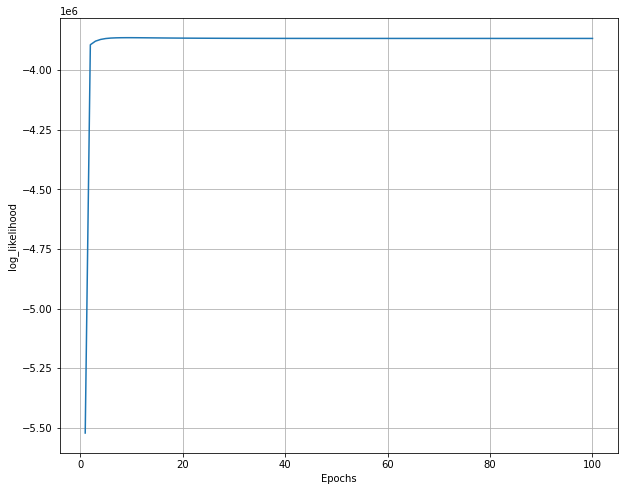

In [1058]:
A.curve_plot()